In [21]:
import pandas as pd
import numpy as np
import nltk

import random

import matplotlib.pyplot as plt

In [17]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mukes\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [36]:
with open("../../data/en_US.twitter.txt", "r", encoding="utf8") as f:
    data = f.read()

In [14]:
def tokenize_sentence(corpus):
    """
    Tokenize sentences in corpus
        Input:
            corpus: large text
        Output:
            tokenized_sentences: 2D list of tokens 
    """
    tokenized_sentences = []
    sentences = corpus.split('\n')

    for sentence in sentences:
        sentence = sentence.lower()
        tokenized = nltk.tokenize.word_tokenize(sentence)
        tokenized_sentences.append(tokenized)
    return tokenized_sentences

In [37]:
tokenized_data = tokenize_sentence(data)
random.seed(32)
random.shuffle(tokenized_data)

train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [38]:
def count_words(tokenized_sentences):
    """
    Creates a word count dict out of tokenized sentences
        Input:
            tokenized_sentences: list of list of words
        Output:
            word_counts: word count dictionary
    """
    word_counts = {}

    for sentence in tokenized_sentences:
        for word in sentence:
            if word in word_counts:
                word_counts[word]+=1
            else:
                word_counts[word]=1
    return word_counts

In [39]:
word_counts = count_words(tokenized_data)

(array([929., 175.,  83.,  53.,  30.,  24.,  17.,  18.,   6.,  12.]),
 array([ 2000.,  6800., 11600., 16400., 21200., 26000., 30800., 35600.,
        40400., 45200., 50000.]),
 <a list of 10 Patch objects>)

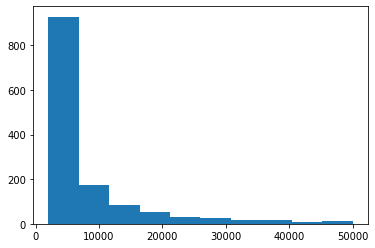

In [ ]:
plt.hist(word_counts.values(), range=(2000, 50000))
plt.show()

In [116]:
len(word_counts), sum([1 for val in word_counts.values() if val>20])

(505137, 32353)

In [46]:
def get_closed_vocab(tokenized_data, threshold):
    """
    Function to create list of words with freq greater than threshold
        Input:
            tokenized_data: list of tokenized sentences
            threshold: int value used as cut off
        Output:
            closed_vocab: list of words with freq greater than threshold
    """
    closed_vocab = []
    word_counts = count_words(tokenized_data)
    for word, count in word_counts.items():
        if count>=threshold:
            closed_vocab.append(word)
    return closed_vocab

In [49]:
def replace_oov(tokenized_sentences, vocab, unk_token='<unk>'):
    """
    Function to replace out of vocabulary words from the tokenized sentences
        Input:
            tokenized_sentences: list of tokenized sentences
            vocab: list of closed vocab of words
            unk_token: token used to replace oov words
        Output:
            replaced_tokenized_sentences: updated tokenized_sentences
    """
    vocabulary = set(vocab)
    replaced_tokenized_sentences = []

    for sentence in tokenized_sentences:
        replaced_sentence = []
        for token in sentence:
            if token in vocabulary:
                replaced_sentence.append(token)
            else:
                replaced_sentence.append(unk_token)
        replaced_tokenized_sentences.append(replaced_sentence)

    return replaced_tokenized_sentences

In [47]:
def preprocess_data(train_data, test_data, count_threshold):
    """
    Helper function to process tokenized data from closed vocabulary
        Input:
            train_data: tokenized train data
            test_data: tokenized test data
            count_threshold: word count used to generate closed vocab
        Output:
            train_data_replaced: processed train data
            test_data_replaced: processed test data
            vocabulary: closed vocab of words
    """
    vocabulary = get_closed_vocab(tokenized_data, count_threshold)
    train_data_replaced = replace_oov(train_data, vocabulary)
    test_data_replaced = replace_oov(test_data, vocabulary)
    
    return train_data_replaced, test_data_replaced, vocabulary

In [50]:
minimum_freq = 2
train_data_processed, test_data_processed, vocabulary = preprocess_data(train_data, test_data, minimum_freq)

# N-gram

In [51]:
def count_n_grams(data, n, start_token='<s>', end_token='<e>'):
    """
    Generate n-gram freq dict
        Input:
            data: list of tokenized seq of words 
            n: value of n to calculate n-grams
            start_token: token to append at the start of sentence
            end_token: token to append at the end of sentence
        Output:
            n_grams: n_gram dict
            
    """
    n_grams = {}

    for sentence in data:
        sentence = [start_token]*n+sentence+[end_token]

        sentence = tuple(sentence)

        m = len(sentence) if n==1 else len(sentence)-1
        for i in range(m):
            n_gram = sentence[i:i+n]

            if n_gram in n_grams:
                n_grams[n_gram] += 1
            else:
                n_grams[n_gram] = 1
    return n_grams

In [69]:
def estimate_prob(word, prev_n_gram, n_gram_counts, n_plus1_gram_counts, vocab_size, k=1):
    """
    Generate prob of next word based on n and n+1 gram counts
        Input:
            word: next word prob to calculate
            prev_n_gram: tuple of words of length n
            n_gram_counts: dict of n_grams and it freq
            n_plus1_gram_counts: dict of nplus1_grams and it freq
            vocab_size: len of vocabulary
            k: constant for smoothning
        Output:
            prob: next word probability
            
    """
    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_count = n_gram_counts.get(prev_n_gram, 0)
    denominator = prev_n_gram_count + vocab_size*k

    n_plus1_gram = prev_n_gram+(word,)

    n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram, 0)
    numerator = n_plus1_gram_count+k

    prob = numerator/denominator

    return prob

In [53]:
def estimate_prob_vocab(prev_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1):
    """
    Generate prob of words from vocabulary based on n and n+1 gram counts
        Input:
            prev_n_gram: tuple of words of length n
            n_gram_counts: dict of n_grams and it freq
            n_plus1_gram_counts: dict of nplus1_grams and it freq
            vocabulary: closed vocab list of words
            k: constant for smoothning
        Output:
            probabilities: dict of vocabulary and their word probs
            
    """
    prev_n_gram = tuple(prev_n_gram)
    vocabulary = vocabulary+['<s>', '<e>']
    vocab_size = len(vocabulary)

    probabilities = {}
    for word in vocabulary:
        prob = estimate_prob(word, prev_n_gram, n_gram_counts, n_plus1_gram_counts, vocab_size, k=k)

        probabilities[word] = prob
    return probabilities    

In [109]:
def generate_seq(n_gram_counts, n_plus1_gram_counts, vocabulary, init_word='<s>', max_len=10, k=1, estimate_prob_vocab=estimate_prob_vocab):
    """
    Helper fuction to generate sequence of words
        Input:
            n_gram_counts: dict of n_grams and it freq
            n_plus1_gram_counts: dict of nplus1_grams and it freq
            vocabulary: closed vocab list of words
            init_word: any random word to initialize the seq
            max_len: max len of the seq generated
            k: constant for smoothning
            estimate_prob_vocab: function to generate probs of the next words from vocab
        Output:
            gen_sentence: generated sequence of words
            
    """
    n = len(list(n_gram_counts.keys())[0])-1
    prev_word = ['<s>']*n+[init_word]
    prev_n_gram = tuple(prev_word)

    i=0
    gen_sentence = [init_word]

    while i < max_len:
        probabilities = estimate_prob_vocab(prev_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=k)

        sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)
        word = sorted_probs[0][0]

        if word == prev_n_gram[-1]:
            word = sorted_probs[1][0]

        if word == '<e>':
            break

        gen_sentence = gen_sentence+[word]
        prev_n_gram = prev_n_gram[1:]+(word,)

        i+=1
    print(' '.join(gen_sentence))

In [113]:
bi_gram = count_n_grams(train_data_processed, 2)
tri_gram = count_n_grams(train_data_processed, 3)

generate_seq(bi_gram, tri_gram, vocabulary, init_word='where')

where are you ?


In [114]:
five_gram = count_n_grams(train_data_processed, 2)
six_gram = count_n_grams(train_data_processed, 3)

generate_seq(five_gram, six_gram, vocabulary, init_word='how')

how many times i 've been waiting for the follow !
